In [0]:
!pip install git+https://github.com/autonomio/talos@daily-dev

In [0]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import talos as ta

from talos.model.early_stopper import early_stopper

from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM, Input, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.activations import relu, elu

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split as split
from bitstring import BitArray


In [178]:
# load the dataset
dataframe = pandas.read_csv('IBM.1Min.TradesOnly.20160128.csv', usecols=[6], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head(5)

,LastTradePrice
0,121.95
1,121.78
2,120.88
3,120.88
4,120.88


In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [139]:
dataset.shape

(409, 1)

In [0]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [181]:
train.shape, test.shape

((286, 1), (123, 1))

In [0]:
 #convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
#plt.plot(train)


In [184]:
trainY.shape, testY.shape

((284,), (121,))

In [0]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# reshape into column arrays
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))
testY=np.reshape(testY, (testY.shape[0], 1))


In [146]:
trainX.shape, testX.shape

((284, 1, 1), (121, 1, 1))

In [0]:
# Segment the train_data based on new window_size; split into train and validation (80/20)
X_train, X_val, y_train, y_val = split(trainX, trainY, test_size = 0.20, random_state = 1120)

In [193]:
X_train[:2]

array([[[0.72631836]],

       [[0.6368408 ]]], dtype=float32)

In [189]:
y_train.shape, y_val.shape

((227, 1), (57, 1))

In [0]:
## Declare params for talos
p = {
    'first_neuron': [12, 24, 48],
    'last_activation': [relu, elu],
    'batch_size': [10, 20, 30],
    'epochs' : [100,200,300]
}

In [0]:
## Talos for optimizing
# create and fit the LSTM network
def talos_model(trainX, trainY, x_val, y_val, params):
    model = Sequential()
    model.add(LSTM(params['first_neuron'], input_shape=(1, look_back)))
    model.add(Dense(1,activation=params['last_activation']))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['acc'])
    out=model.fit(trainX, trainY, epochs=params['epochs'], batch_size=params['batch_size'], verbose=2,validation_data=[x_val, y_val])                    
    return out, model
    

In [0]:

h = ta.Scan(X_train, y_train, params= p, model=talos_model, x_val=X_val, y_val=y_val)

In [195]:
# accessing the results data frame
h.data.head()

# accessing epoch entropy values for each round
h.peak_epochs_df

# access the summary details
h.details

complete_time            01/24/19/06:33
experiment_name           012419062424_
grid_downsample                    None
random_method          uniform_mersenne
reduce_loss                       False
reduction_interval                   50
reduction_method                   None
reduction_metric                val_acc
reduction_threshold                 0.2
reduction_window                     20
x_shape                     (227, 1, 1)
y_shape                        (227, 1)
dtype: object

In [214]:

testY.shape

(121, 1)

In [0]:
# use Scan object as input
r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('012419062424_.csv')

In [197]:
r.data.head(-3)

,round_epochs,val_loss,val_acc,loss,acc,first_neuron,last_activation,batch_size,epochs
0,300,0.002602,0.0,0.004961,0.013216,48,<function relu at 0x7f9bc37ed0d0>,10,300
1,200,0.307730,0.0,0.275389,0.013216,48,<function relu at 0x7f9bc37ed0d0>,20,200
2,300,0.002599,0.0,0.004987,0.013216,24,<function elu at 0x7f9bc3861e18>,10,300
3,300,0.307730,0.0,0.275389,0.013216,12,<function relu at 0x7f9bc37ed0d0>,30,300
4,100,0.002744,0.0,0.004997,0.013216,24,<function elu at 0x7f9bc3861e18>,20,100
5,100,0.002784,0.0,0.004996,0.013216,48,<function elu at 0x7f9bc3861e18>,30,100
6,300,0.002655,0.0,0.004935,0.013216,48,<function relu at 0x7f9bc37ed0d0>,20,300
7,200,0.002654,0.0,0.004986,0.013216,48,<function elu at 0x7f9bc3861e18>,20,200
8,300,0.002678,0.0,0.004966,0.013216,48,<function relu at 0x7f9bc37ed0d0>,30,300
9,200,0.002591,0.0,0.004996,0.013216,12,<function elu at 0x7f9bc3861e18>,10,200


In [60]:

# access the dataframe with the results
r.data.head(-3)

# get the number of rounds in the Scan
r.rounds()

# get the highest result ('val_acc' by default)
r.high()

# get the highest result for any metric
r.high('acc')

# get the round with the best result
r.rounds2high()

# get the best paramaters
r.best_params()

# get correlation for hyperparameters against a metric
r.correlate('val_loss')

first_neuron   -0.033338
batch_size     -0.100898
epochs         -0.050929
Name: val_loss, dtype: float64

In [0]:
r.best_params()[1]

In [0]:
# a regression plot for two dimensions 
r.plot_regs()

# line plot
r.plot_line()

# a simple histogram
r.plot_hist(bins=50)

# heatmap correlation
r.plot_corr()

# a four dimensional bar grid
r.plot_bars('batch_size', 'acc', 'epochs', 'first_neuron')

In [0]:
# Predict on train and test
p=ta.Predict(h)

trainPredict = p.predict(X_train, metric='val_acc')
valPredict = p.predict(X_val, metric='val_acc')
testPredict = p.predict(testX, metric='val_acc')


In [219]:
trainPredict.shape, y_train.shape


((227, 1), (227, 1))

In [0]:
# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)


testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [220]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 0.10 RMSE


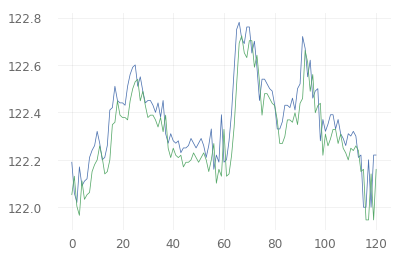

In [228]:
plt.plot(testY)
plt.plot(testPredict)


In [0]:
%matplotlib inline

In [0]:

# evaluating model

e = ta.Evaluate(h)
e.evaluate(X_train, y_train, folds=10, metric='metric='val_acc'')
ta.Deploy(h, 'out1');
## Restore model from zip file
i2 = ta.Restore('i2.zip')

## Predict the data using saved model
#trainPredict=i2.model.predict(trainX)
testPredict=i2.model.predict(testX)